In [ ]:
import pandas as pd

# List of participant IDs and number of files per participant
participants = [1, 2, 3, 4]  # 4 participants

# Function to load data and split into train, validation, and test
def load_and_split_eda_data(participants):
    train_data = []
    val_data = []
    test_data = []

    for participant in participants:
        for file_num in range(1, 11):  # Assuming 10 files per participant
            file_path = f'EDA_{participant}_{file_num}.csv'  # Adjust path
            df = pd.read_csv(file_path, skiprows=3, header=None)
            df.columns = ['EDA']
            df['Participant'] = participant
            df['File'] = file_num

            # Split the data according to the file number
            if file_num <= 8:
                train_data.append(df)
            elif file_num == 9:
                val_data.append(df)
            elif file_num == 10:
                test_data.append(df)

    # Concatenate all the files into one dataframe for each split
    train_data = pd.concat(train_data, ignore_index=True)
    val_data = pd.concat(val_data, ignore_index=True)
    test_data = pd.concat(test_data, ignore_index=True)

    return train_data, val_data, test_data

# Load and split the data
train_data, val_data, test_data = load_and_split_eda_data(participants)

# Check the data splits
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (80254, 3)
Validation data shape: (11372, 3)
Test data shape: (10106, 3)


In [ ]:
# Placeholder function to extract phasic and tonic components
def extract_phasic_tonic(eda_signal):
    phasic_component = eda_signal.rolling(window=20).mean()  # Simplified example
    tonic_component = eda_signal - phasic_component  # Simplified example
    return phasic_component, tonic_component

# Apply phasic and tonic extraction
train_data['Phasic'], train_data['Tonic'] = extract_phasic_tonic(train_data['EDA'])
val_data['Phasic'], val_data['Tonic'] = extract_phasic_tonic(val_data['EDA'])
test_data['Phasic'], test_data['Tonic'] = extract_phasic_tonic(test_data['EDA'])

# Drop any NaN values due to rolling operations
train_data.dropna(inplace=True)
val_data.dropna(inplace=True)
test_data.dropna(inplace=True)


In [ ]:
# Function to create lagged features
def create_features(df, n_lags=5):
    for lag in range(1, n_lags + 1):
        df[f'Phasic_lag_{lag}'] = df['Phasic'].shift(lag)
        df[f'Tonic_lag_{lag}'] = df['Tonic'].shift(lag)
    df.dropna(inplace=True)  # Drop rows with NaN values after shifting
    return df

# Apply feature engineering to train, validation, and test sets
train_data = create_features(train_data)
val_data = create_features(val_data)
test_data = create_features(test_data)

# Define features and target
features = [col for col in train_data.columns if 'lag' in col]
target = 'EDA'


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])
test_data[features] = scaler.transform(test_data[features])

# Function to prepare data for LSTM (converting into 3D sequences)
def create_lstm_data(df, target, features, time_steps=10):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df[features].iloc[i:i+time_steps].values)
        y.append(df[target].iloc[i+time_steps])
    return np.array(X), np.array(y)

# Create LSTM sequences
time_steps = 10
X_train, y_train = create_lstm_data(train_data, target, features, time_steps)
X_val, y_val = create_lstm_data(val_data, target, features, time_steps)
X_test, y_test = create_lstm_data(test_data, target, features, time_steps)

print("LSTM data shapes:", X_train.shape, X_val.shape, X_test.shape)


LSTM data shapes: (80220, 10, 10) (11338, 10, 10) (10072, 10, 10)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.0281 - val_loss: 0.0013
Epoch 2/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0054 - val_loss: 9.0157e-04
Epoch 3/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 4/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0039 - val_loss: 9.7501e-04
Epoch 5/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 6/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0035 - val_loss: 9.9364e-04
Epoch 7/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 8/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0036 - val_loss: 9.2974e-04
Epoch 9/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0034 - val_loss: 9.3277e-04
Epoch 10/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0037 - val_loss: 8.8491e-04
Epoch 11/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0035 - v

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,355 (380.30 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,904 (253.54 KB)

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, recall_score, roc_auc_score

# Predict on validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Evaluate the model on val set
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"val RMSE: {rmse_val}")

# Convert predictions to binary for classification metrics
y_val_pred_binary = np.where(y_val_pred > y_val.mean(), 1, 0)
y_val_binary = np.where(y_val > y_val.mean(), 1, 0)

accuracy_val = accuracy_score(y_val_binary, y_val_pred_binary)
f1_val = f1_score(y_val_binary, y_val_pred_binary)
sensitivity_val = recall_score(y_val_binary, y_val_pred_binary)
auroc_val = roc_auc_score(y_val_binary, y_val_pred_binary)

print(f"val Accuracy: {accuracy_val}")
print(f"val F1 Score: {f1_val}")
print(f"val Sensitivity: {sensitivity_val}")
print(f"val AUROC: {auroc_val}")

# Evaluate the model on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {rmse_test}")

# Convert predictions to binary for classification metrics
y_test_pred_binary = np.where(y_test_pred > y_test.mean(), 1, 0)
y_test_binary = np.where(y_test > y_test.mean(), 1, 0)

accuracy_test = accuracy_score(y_test_binary, y_test_pred_binary)
f1_test = f1_score(y_test_binary, y_test_pred_binary)
sensitivity_test = recall_score(y_test_binary, y_test_pred_binary)
auroc_test = roc_auc_score(y_test_binary, y_test_pred_binary)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Sensitivity: {sensitivity_test}")
print(f"Test AUROC: {auroc_test}")


355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
val RMSE: 0.030173338535031
val Accuracy: 0.999294408184865
val F1 Score: 0.9986173522295195
val Sensitivity: 0.9982722874913614
val AUROC: 0.9989585028172107
Test RMSE: 0.05318036710124899
Test Accuracy: 0.999801429706116
Test F1 Score: 0.9996156802459647
Test Sensitivity: 0.9992316557817903
Test AUROC: 0.9996158278908951


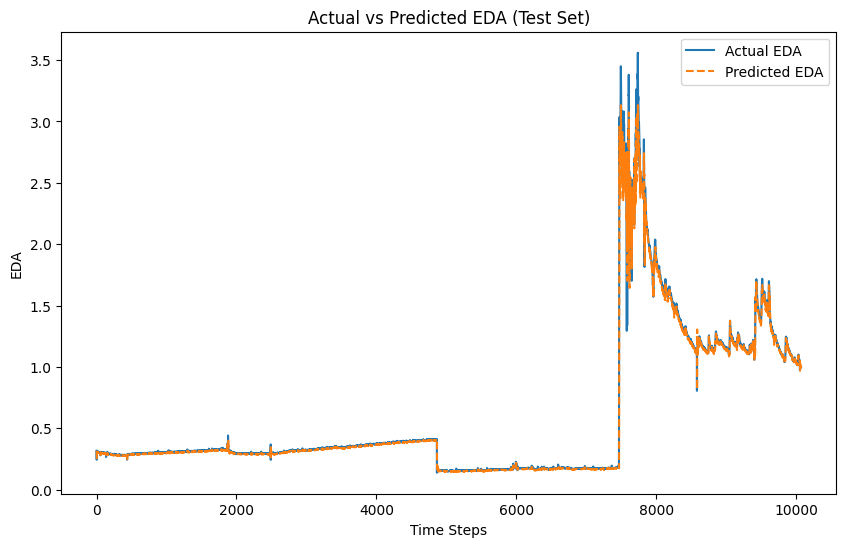

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual EDA')
plt.plot(y_test_pred, label='Predicted EDA', linestyle='dashed')
plt.title('Actual vs Predicted EDA (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('EDA')
plt.legend()
plt.show()


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


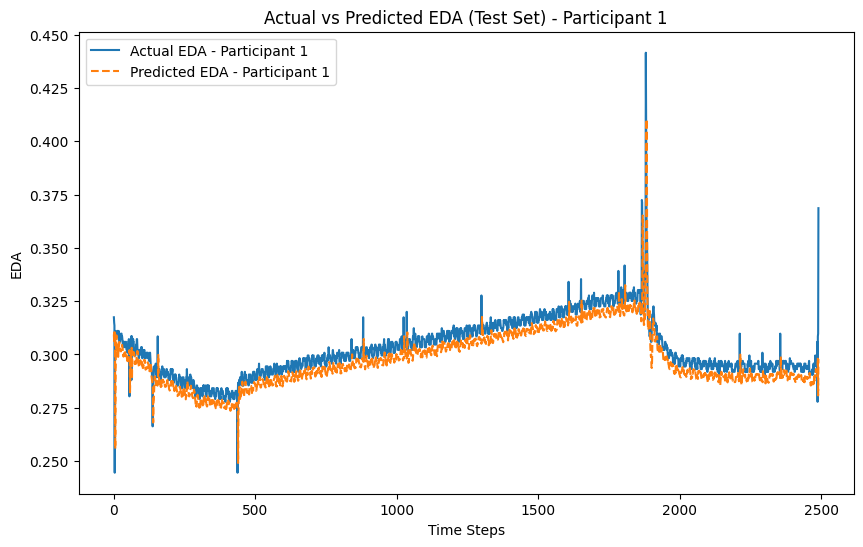

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


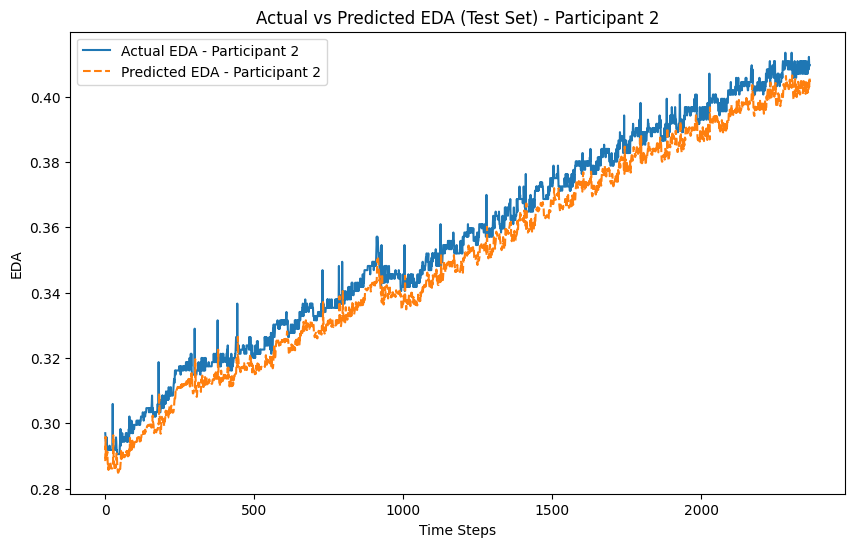

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


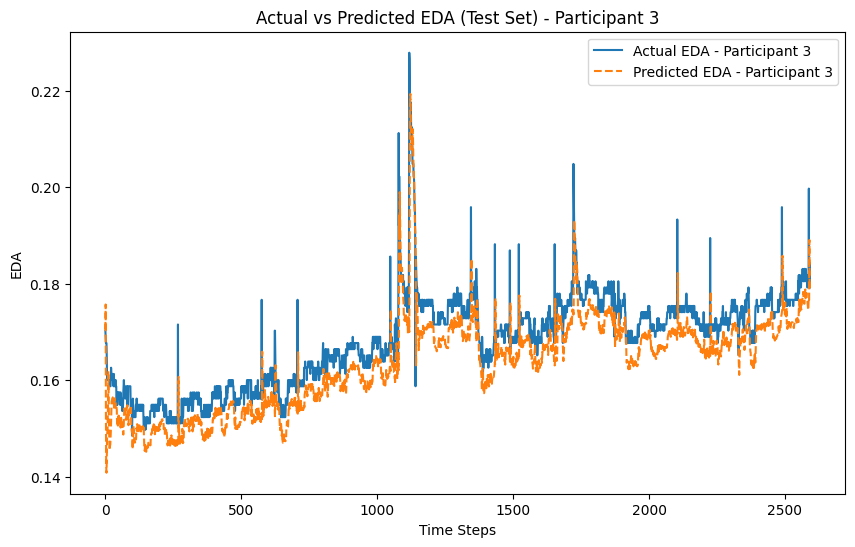

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


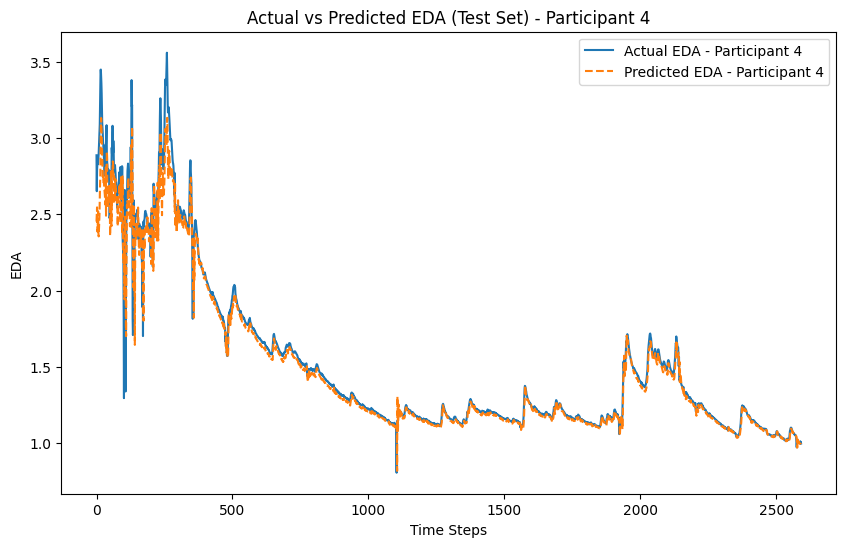

In [ ]:
# Function to create LSTM data per participant for plotting
def create_lstm_data_by_participant(df, target, features, time_steps=10):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df[features].iloc[i:i+time_steps].values)
        y.append(df[target].iloc[i+time_steps])
    return np.array(X), np.array(y)

# Extract the test data for a specific participant and plot actual vs predicted
def plot_test_results_by_participant(test_data, model, participants, features, target, time_steps=10):
    for participant in participants:
        # Filter the test data for the current participant
        participant_test_data = test_data[test_data['Participant'] == participant]

        # Create LSTM input for this participant
        X_participant, y_participant = create_lstm_data_by_participant(participant_test_data, target, features, time_steps)

        # Predict for this participant
        y_participant_pred = model.predict(X_participant)

        # Plot actual vs predicted for the participant
        plt.figure(figsize=(10, 6))
        plt.plot(y_participant, label=f'Actual EDA - Participant {participant}')
        plt.plot(y_participant_pred, label=f'Predicted EDA - Participant {participant}', linestyle='dashed')
        plt.title(f'Actual vs Predicted EDA (Test Set) - Participant {participant}')
        plt.xlabel('Time Steps')
        plt.ylabel('EDA')
        plt.legend()
        plt.show()

# Now call the function to plot for each participant
plot_test_results_by_participant(test_data, model, participants, features, target, time_steps)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load new EDA data file
def load_new_eda_data(file_path):
    df = pd.read_csv(file_path, skiprows=3, header=None)
    df.columns = ['EDA']
    return df

# Load the new file (Replace with the correct path)
file_test = 'EDA_Testing.csv'
new_data = load_new_eda_data(file_test)

# Extract Phasic and Tonic components (same as before)
def extract_phasic_tonic(eda_signal):
    phasic_component = eda_signal.rolling(window=20).mean()
    tonic_component = eda_signal - phasic_component
    return phasic_component, tonic_component

# Apply the extraction
new_data['Phasic'], new_data['Tonic'] = extract_phasic_tonic(new_data['EDA'])
new_data.dropna(inplace=True)  # Drop NaNs due to rolling window

# Standardize the data using the same scaler used previously
scaler = StandardScaler()
features = ['Phasic', 'Tonic']

new_data[features] = scaler.fit_transform(new_data[features])


In [ ]:
# 80-20 split
split_index = int(len(new_data) * 0.8)
train_new = new_data.iloc[:split_index]
test_new = new_data.iloc[split_index:]

# Create the lag features for consistency
def create_features(df, n_lags=5):
    for lag in range(1, n_lags + 1):
        df[f'Phasic_lag_{lag}'] = df['Phasic'].shift(lag)
        df[f'Tonic_lag_{lag}'] = df['Tonic'].shift(lag)
    df.dropna(inplace=True)  # Drop rows with NaNs
    return df

# Apply feature engineering
train_new = create_features(train_new)
test_new = create_features(test_new)

# Extract feature columns
lag_features = [col for col in train_new.columns if 'lag' in col]

# Reshape the data into the 3D shape required by LSTM/Transformer models
def create_lstm_test_data(df, features, time_steps=10):
    X = []
    for i in range(len(df) - time_steps):
        X.append(df[features].iloc[i:i + time_steps].values)
    return np.array(X)

# Create input data for 80% (train) part
X_test_input = create_lstm_test_data(train_new, lag_features)


<ipython-input-10-4ba463306feb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Phasic_lag_{lag}'] = df['Phasic'].shift(lag)
<ipython-input-10-4ba463306feb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'Tonic_lag_{lag}'] = df['Tonic'].shift(lag)
<ipython-input-10-4ba463306feb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
# Ensure we are using the right shape for `current_input`
final_input_sequence = train_new[lag_features].values[-X_test_input.shape[1]:]
final_input_sequence = final_input_sequence.reshape((1, X_test_input.shape[1], len(lag_features)))

# Predict iteratively for the 20% test data using the trained model
predicted_20_lstm = []
current_input = final_input_sequence

for _ in range(len(test_new) - X_test_input.shape[1]):
    next_pred = model.predict(current_input)  # Predict next value
    predicted_20_lstm.append(next_pred[0][0])  # Collect prediction

    # Prepare the next input sequence
    # Remove the oldest time step and add the new predicted step
    next_input = np.append(current_input[:, 1:, :], [[[next_pred[0][0]] * len(lag_features)]], axis=1)
    current_input = next_input

predicted_20_lstm = np.array(predicted_20_lstm)

# Ensure that the length matches the actual test data values
actual_20_lstm = test_new['EDA'].values[:len(predicted_20_lstm)]

print(f"Length of predicted values: {len(predicted_20_lstm)}")
print(f"Length of actual values: {len(actual_20_lstm)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Build the GRU model
model = Sequential()

# Add GRU layers with dropout to prevent overfitting
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.2))

# Output layer for regression
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
history_gru = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Model summary
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 70s 25ms/step - loss: 0.0311 - val_loss: 0.0027
Epoch 2/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 3/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.0041 - val_loss: 9.8926e-04
Epoch 4/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.0038 - val_loss: 8.7823e-04
Epoch 5/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 6/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0039 - val_loss: 9.7492e-04
Epoch 7/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 8/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.0036 - val_loss: 9.3501e-04
Epoch 9/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 10/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0035 - val_loss: 9.7746e-04
Epoch 11/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0036 - val_l

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 50)              │           9,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,955 (288.89 KB)

 Trainable params: 24,651 (96.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 49,304 (192.60 KB)

In [ ]:
# Evaluate the model on the val set
y_val_pred_gru = model.predict(X_val)

# Calculate metrics
rmse_val_gru = np.sqrt(mean_squared_error(y_val, y_val_pred_gru))
print(f"val RMSE for GRU: {rmse_val_gru}")

# Binary classification metrics
y_val_pred_gru_binary = np.where(y_val_pred_gru > y_val.mean(), 1, 0)
y_val_binary = np.where(y_val > y_val.mean(), 1, 0)

accuracy_val_gru = accuracy_score(y_val_binary, y_val_pred_gru_binary)
f1_val_gru = f1_score(y_val_binary, y_val_pred_gru_binary)
sensitivity_val_gru = recall_score(y_val_binary, y_val_pred_gru_binary)
auroc_val_gru = roc_auc_score(y_val_binary, y_val_pred_gru_binary)

print(f"GRU val Accuracy: {accuracy_val_gru}")
print(f"GRU val F1 Score: {f1_val_gru}")
print(f"GRU val Sensitivity: {sensitivity_val_gru}")
print(f"GRU val AUROC: {auroc_val_gru}")


# Evaluate the model on the test set
y_test_pred_gru = model.predict(X_test)

# Calculate metrics
rmse_test_gru = np.sqrt(mean_squared_error(y_test, y_test_pred_gru))
print(f"Test RMSE for GRU: {rmse_test_gru}")

# Binary classification metrics
y_test_pred_gru_binary = np.where(y_test_pred_gru > y_test.mean(), 1, 0)
y_test_binary = np.where(y_test > y_test.mean(), 1, 0)

accuracy_test_gru = accuracy_score(y_test_binary, y_test_pred_gru_binary)
f1_test_gru = f1_score(y_test_binary, y_test_pred_gru_binary)
sensitivity_test_gru = recall_score(y_test_binary, y_test_pred_gru_binary)
auroc_test_gru = roc_auc_score(y_test_binary, y_test_pred_gru_binary)

print(f"GRU Test Accuracy: {accuracy_test_gru}")
print(f"GRU Test F1 Score: {f1_test_gru}")
print(f"GRU Test Sensitivity: {sensitivity_test_gru}")
print(f"GRU Test AUROC: {auroc_test_gru}")


355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
val RMSE for GRU: 0.02738665872267427
GRU val Accuracy: 0.9994708061386488
GRU val F1 Score: 0.9989626556016596
GRU val Sensitivity: 0.9982722874913614
GRU val AUROC: 0.9990769301028574
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test RMSE for GRU: 0.06864181666324935
GRU Test Accuracy: 0.999801429706116
GRU Test F1 Score: 0.9996156802459647
GRU Test Sensitivity: 0.9992316557817903
GRU Test AUROC: 0.9996158278908951


In [ ]:
from tensorflow.keras.layers import Bidirectional

# Build the Bidirectional LSTM model
model_bilstm = Sequential()

# Add Bidirectional LSTM layers with dropout
model_bilstm.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bilstm.add(Dropout(0.2))

model_bilstm.add(Bidirectional(LSTM(units=50)))
model_bilstm.add(Dropout(0.2))

# Output layer
model_bilstm.add(Dense(units=1))

# Compile the model
model_bilstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the BiLSTM model
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Model summary
model_bilstm.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 86s 29ms/step - loss: 0.0198 - val_loss: 0.0014
Epoch 2/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 74s 26ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 3/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step - loss: 0.0029 - val_loss: 9.4773e-04
Epoch 4/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 5/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 6/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 83s 23ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 7/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 8/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 9/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 78s 23ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 10/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 11/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - loss: 0.0025 - val_loss: 9.7159e-04


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 10, 100)             │          24,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,705 (994.95 KB)

 Trainable params: 84,901 (331.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,804 (663.30 KB)

In [ ]:
# Evaluate the model on the val set
y_val_pred_bilstm = model_bilstm.predict(X_val)

# Calculate metrics
rmse_val_bilstm = np.sqrt(mean_squared_error(y_val, y_val_pred_bilstm))
print(f"val RMSE for BiLSTM: {rmse_val_bilstm}")

# Binary classification metrics
y_val_pred_bilstm_binary = np.where(y_val_pred_bilstm > y_val.mean(), 1, 0)

accuracy_val_bilstm = accuracy_score(y_val_binary, y_val_pred_bilstm_binary)
f1_val_bilstm = f1_score(y_val_binary, y_val_pred_bilstm_binary)
sensitivity_val_bilstm = recall_score(y_val_binary, y_val_pred_bilstm_binary)
auroc_val_bilstm = roc_auc_score(y_val_binary, y_val_pred_bilstm_binary)

print(f"BiLSTM val Accuracy: {accuracy_val_bilstm}")
print(f"BiLSTM val F1 Score: {f1_val_bilstm}")
print(f"BiLSTM val Sensitivity: {sensitivity_val_bilstm}")
print(f"BiLSTM val AUROC: {auroc_val_bilstm}")

# Evaluate the model on the test set
y_test_pred_bilstm = model_bilstm.predict(X_test)

# Calculate metrics
rmse_test_bilstm = np.sqrt(mean_squared_error(y_test, y_test_pred_bilstm))
print(f"Test RMSE for BiLSTM: {rmse_test_bilstm}")

# Binary classification metrics
y_test_pred_bilstm_binary = np.where(y_test_pred_bilstm > y_test.mean(), 1, 0)

accuracy_test_bilstm = accuracy_score(y_test_binary, y_test_pred_bilstm_binary)
f1_test_bilstm = f1_score(y_test_binary, y_test_pred_bilstm_binary)
sensitivity_test_bilstm = recall_score(y_test_binary, y_test_pred_bilstm_binary)
auroc_test_bilstm = roc_auc_score(y_test_binary, y_test_pred_bilstm_binary)

print(f"BiLSTM Test Accuracy: {accuracy_test_bilstm}")
print(f"BiLSTM Test F1 Score: {f1_test_bilstm}")
print(f"BiLSTM Test Sensitivity: {sensitivity_test_bilstm}")
print(f"BiLSTM Test AUROC: {auroc_test_bilstm}")

355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
val RMSE for BiLSTM: 0.027834526301703227
BiLSTM val Accuracy: 0.999294408184865
BiLSTM val F1 Score: 0.9986173522295195
BiLSTM val Sensitivity: 0.9982722874913614
BiLSTM val AUROC: 0.9989585028172107
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Test RMSE for BiLSTM: 0.05491913629719366
BiLSTM Test Accuracy: 0.999801429706116
BiLSTM Test F1 Score: 0.9996156802459647
BiLSTM Test Sensitivity: 0.9992316557817903
BiLSTM Test AUROC: 0.9996158278908951
